# Fitting the SOHO/VIRGO Solar Irradiance Power Spectrum

##### Brett Morris

In [1]:
%matplotlib inline
import os
import json
from functools import partial

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.stats import mad_std

from gadfly import PowerSpectrum, scale
from gadfly.sun import broomhall_p_mode_freqs

from gadfly.psd import (
    linear_space_to_jax_parameterization, 
    jax_parameterization_to_linear_space,
    linear_space_to_dicts, ppm, to_psd_units,
)

from scipy.stats import binned_statistic
from lightkurve import LightCurve

from jax import jit, lax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
# from jax import config
# config.update('jax_debug_nans', True)

from celerite2.jax import GaussianProcess, terms

celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax.config import config
>>> config.update('jax_enable_x64', True)


The VIRGO/PMO6 1-minute time series is accessible online at: 

    ftp://ftp.pmodwrc.ch/pub/data/irradiance/virgo/old/1-minute_Data/VIRGO_1min_0083-7404.fits
    
We first load the VIRGO observations:

In [2]:
hdu = fits.open('data/VIRGO_1min_0083-7404.fits.gz')
raw_fluxes = hdu[0].data
header = hdu[0].header

header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Thu Jun 09 12:12:01 2016      
BITPIX  =                  -64 /                                                
NAXIS   =                    1 /                                                
NAXIS1  =             10543680 /                                                
DATE    = '09/06/16'           / FITS file creation date (dd-mm-yyyy)           
EXTEND  =                    T / FILE MAY CONTAIN EXTENSIONS                    
ORIGIN  = 'PMOD/WRC'           /                                                
TELESCOP= 'SOHO'               /                                                
INSTRUME= 'PMO6V on VIRGO'     /                                                
START   = '22-02-1996'         / Start date  (dd-mm-yyyy)                       
STOPP   = '09-03-2016'         / End date  (dd-mm-yyyy)                         
SAMPLE  = 60.0000              / Sampling (sec)                                 
TIME    =      83.0002315   

We can reconstruct the times from the background info in the header. We will linearly interpolate over missing measurements. 

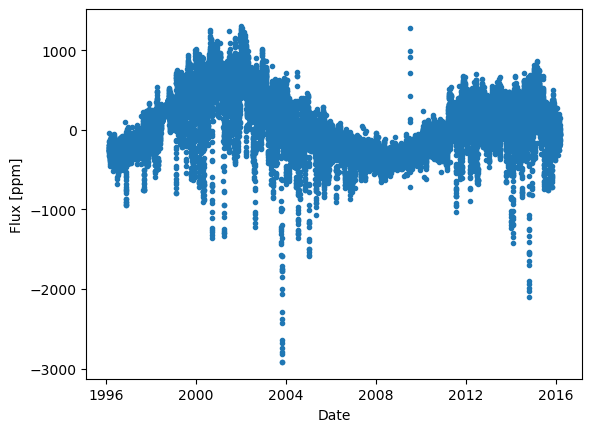

In [3]:
soho_mission_day = Time("1995-12-1 00:00")

times = (
    soho_mission_day.jd + 
    header['TIME'] + 
    np.arange(header['NAXIS1']) / 1440
)
times_astropy = Time(times, format='jd')

fluxes = raw_fluxes.copy()
interp_fluxes = np.interp(
    times[raw_fluxes == -99], times[raw_fluxes != -99], fluxes[raw_fluxes != -99]
)
d = (times[1] - times[0]) * u.day

fluxes[raw_fluxes == -99] = interp_fluxes

fluxes = 1e6 * (fluxes / np.median(fluxes) - 1) * ppm
fluxes_std_ppm = mad_std(fluxes.value)

skip_every = 500
plt.plot_date(
    times_astropy.plot_date[::skip_every], 
    fluxes[::skip_every], fmt='.'
)
plt.xlabel('Date')
plt.ylabel(f'Flux [{fluxes.unit}]');

Compute the full and binned power spectrum: 

In [4]:
solar_light_curve = LightCurve(
    time=times_astropy, 
    flux=fluxes
)

solar_power_spectrum = PowerSpectrum.from_light_curve(
    solar_light_curve, detrend=False
)
# this binned power spectrum will be used for fitting low-frequency
# components ([super-/meso-/]granulation)
solar_power_spectrum_binned = solar_power_spectrum.bin(len(fluxes) // 10000, constant=1)

In [5]:
n_p_mode_bins = 5000

# This binned, cropped power spectrum is useful for fitting p-modes
p_mode_binned = solar_power_spectrum.cutout(2000*u.uHz, 4000*u.uHz).bin(n_p_mode_bins)

# This binned, cropped power spectrum is useful for plotting the p-mode fit
p_mode_bin_for_plot = solar_power_spectrum.cutout(1800*u.uHz, 4000*u.uHz).bin(n_p_mode_bins)

(<Figure size 1500x500 with 1 Axes>,
 <AxesSubplot: xlabel='Frequency [$\\mu$Hz]', ylabel='Power [ppm$^2$ / $\\mu$Hz]'>)

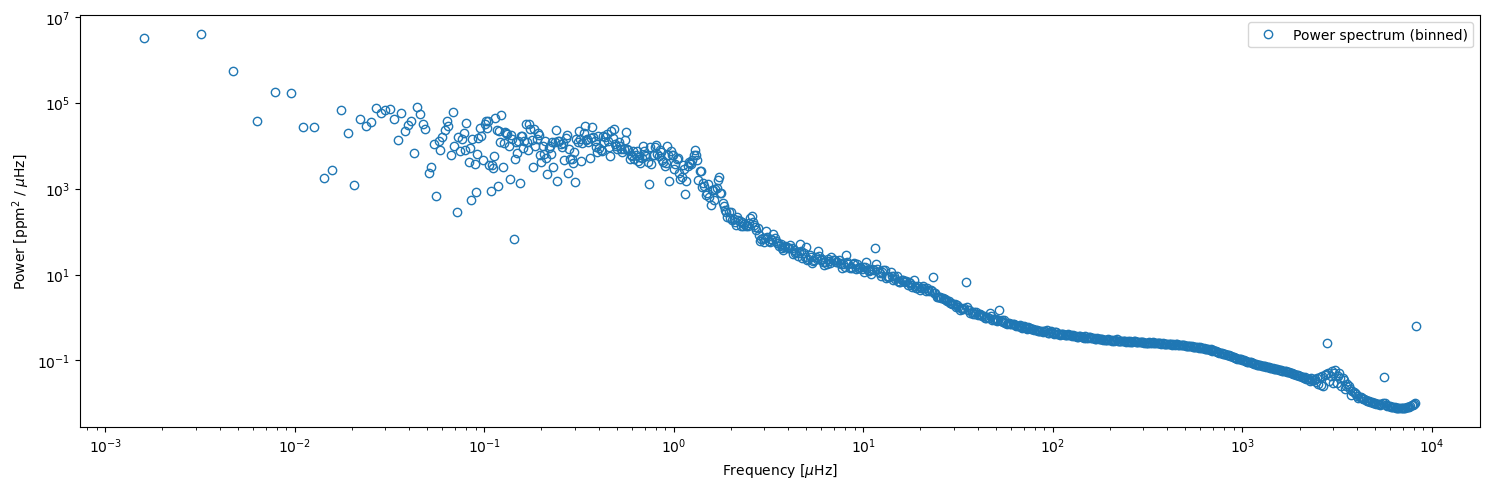

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
solar_power_spectrum_binned.plot(
    ax=ax, p_mode_inset=False
)

Narrow our set some boundaries in frequency over which we will fit the power spectrum:

In [7]:
# Set the max frequency to be near the peak in the p-modes
cutoff_freq_max = 3000 * u.uHz
# Set the min frequency to be low
cutoff_freq_min = 0.1 * u.uHz

in_bounds = (
    (solar_power_spectrum_binned.frequency < cutoff_freq_max) &
    (solar_power_spectrum_binned.frequency > cutoff_freq_min)
)

y = to_psd_units(
    solar_power_spectrum_binned.power[in_bounds]
).value

yerr = to_psd_units(
    solar_power_spectrum_binned.error[in_bounds]
).value

x = solar_power_spectrum_binned.frequency[in_bounds].to(u.uHz).value

# # Make sure no NaNs make it into the calculations below:
mask_y = np.logical_not(np.isnan(y))
x = x[mask_y]

yerr_obs = yerr[mask_y].copy()

# The uncertainties produced during the binning in `yerr`
# are good for high frequencies, where the statistics are 
# reliable. We can estimate a "noise floor" as a function
# of frequency, which we've done by eye and has these parameters:
alpha = 8e3
beta = -1.7
yerr = np.nanmax([yerr[mask_y], alpha * x[mask_y] ** beta], axis=0)

# Now take the min of the the yerrs and the noise floor:
y = y[mask_y]
noise_floor = 0.1
mask_fix_yerr = np.isnan(yerr) | (yerr <= 0) | (yerr / y < noise_floor)
yerr[mask_fix_yerr] = noise_floor * y[mask_fix_yerr]

noise_floor_plot = False

if noise_floor_plot:
    plt.loglog(x, yerr)
    plt.loglog(x, yerr_obs)
    plt.plot(x, alpha * x ** beta)

Fit the low-frequency features in the solar power spectrum.

In [50]:
# Get the frequencies at the p-mode peaks from Broomhall et al. (2009):
p_mode_freqs = broomhall_p_mode_freqs()

# We'll scale the uncertainties near the p-modes by a factor
# proportional to the amplitudes of the p-mode envelope:
errorbar_scale_factor = (
    50 * scale._p_mode_intensity_kjeldsen_bedding(x * u.uHz).value/20.1 + 1
)

In [9]:
# def finite_integration_time(omega, delta):
#     arg = 0.5 * delta * omega
#     sinc = np.ones_like(arg)
#     m = np.abs(arg) > 0.0
#     sinc[m] = np.sin(arg[m]) / arg[m]
#     return sinc**2
    
# delta = (1*u.min).to(1/u.uHz).value
# omega = 2 * np.pi * solar_power_spectrum_binned.frequency.to(u.uHz).value
# plt.loglog(omega, sho_psd(omega, 1, 3000, 0.6) * finite_integration_time(omega, delta))

Fit successful: True


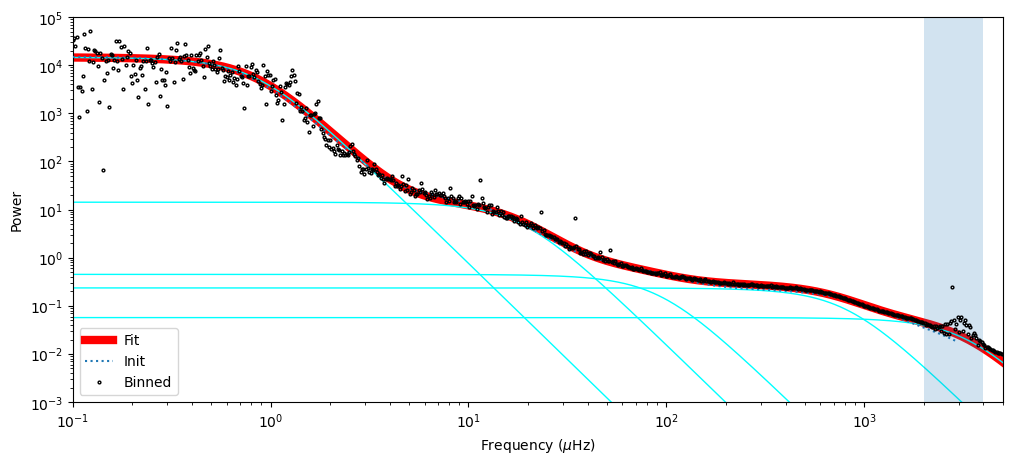

In [10]:
# This fixed value for Q should be close to the critical value of 0.5:
fixed_Q = 0.6

min_p_mode = 2000  # Assume p-modes start about here in uHz
max_p_mode = 4000 # Assume p-modes end about here in uHz

mask_p_modes = (x < min_p_mode) | (x > max_p_mode)

def sho(S0, w0, Q=fixed_Q):
    """
    Underdamped SHO kernel from celerite2
    """
    return terms.UnderdampedSHOTerm(
        S0=S0, w0=w0, Q=Q
    )

def low_freq_kernels_five_kernels(p):
    """
    Sum of five underdamped SHO kernels, meant for fitting
    low frequency features in the solar power spectrum.
    """
    delta_S0_0, w0_0 = p[0:2]
    delta_S0_1, delta_w0_1 = p[2:4]
    delta_S0_2, delta_w0_2 = p[4:6]
    delta_S0_3, delta_w0_3 = p[6:8]
    S0_4, delta_w0_4 = p[8:10]
    
    S0_3 = 10 ** delta_S0_3 + S0_4
    S0_2 = 10 ** delta_S0_2 + S0_3
    S0_1 = 10 ** delta_S0_1 + S0_2
    S0_0 = 10 ** delta_S0_0 + S0_1
    
    w0_1 = w0_0 + 10 ** delta_w0_1
    w0_2 = w0_1 + 10 ** delta_w0_2
    w0_3 = w0_2 + 10 ** delta_w0_3
    w0_4 = w0_3 + 10 ** delta_w0_4
    
    kernel = terms.TermSum(
        sho(S0_0, w0_0),
        sho(S0_1, w0_1), 
        sho(S0_2, w0_2),
        sho(S0_3, w0_3),
        sho(S0_4, w0_4),
    )
    
    return kernel

def jax_model_low_freq(p, omega):
    """
    Model of the low-frequency power spectrum, computed
    at angular frequencies ``omega``.
    """
    psd = low_freq_kernels_five_kernels(p).get_psd(omega)
    return psd

def jax_model_low_freq_terms(p, omega):
    """
    Model of the low-frequency power spectrum, computed
    at angular frequencies ``omega``.
    """
    psds = [trm.get_psd(omega) for trm in low_freq_kernels_five_kernels(p).terms]
    return psds

@partial(jit, static_argnums=(1, 2, 3))
def chi2_low_freq_model(
    p, 
    y=y, omega=2*np.pi*x, yerr=jnp.where(mask_p_modes, 1, errorbar_scale_factor) * yerr
):
    """
    chi^2 of the low-frequency model
    """
    chi2_result = jnp.nansum( 
        (y - jax_model_low_freq(p, omega=omega))**2  / yerr**2
    )
    return chi2_result


fit = True

all_S0s = 1.5 * 10 ** np.array([4.1, 1.2, -0.3, -0.8, -1.5])
all_omegas = np.array([5e0, 9.5e1, 6e2, 6.3e3, 2.0e4])

initp = linear_space_to_jax_parameterization(all_S0s, all_omegas)

fig, ax = plt.subplots(figsize=(12, 5))

if fit:
    result = minimize(
        chi2_low_freq_model, jnp.array(initp), method='bfgs',
    )
    print('Fit successful:', result.success)
    if result.status == 3:
        # status message keys source/docs
        # https://github.com/scipy/scipy/blob/85d25b6e4a9b95371e48bae75c19459a0b77d18e/scipy/optimize/_optimize.py#L1239-L1242
        print('Warning: nans encountered in optimization')
    bestp_lowfreq = result.x

def numpy_model(p, omega=2*np.pi*x):
    return np.array(jax_model_low_freq(p, omega=omega))

def numpy_model_terms(p, omega=2*np.pi*x):
    return jax_model_low_freq_terms(p, omega)

if fit:
    ax.loglog(solar_power_spectrum_binned.frequency.value, 
              numpy_model(bestp_lowfreq, omega=2*np.pi*solar_power_spectrum_binned.frequency.value), 
              color='r', lw=6, label='Fit', zorder=0)
    for trm in numpy_model_terms(bestp_lowfreq, omega=2*np.pi*solar_power_spectrum_binned.frequency.value):
        ax.loglog(solar_power_spectrum_binned.frequency.value, np.array(trm), color='cyan', lw=1, zorder=0)
ax.loglog(x, numpy_model(initp), color='C0', ls=':', label='Init', zorder=10)
ax.errorbar(solar_power_spectrum_binned.frequency.value, solar_power_spectrum_binned.power.value, None, 
            color='k', ecolor='silver', label='Binned', fmt='.', ms=4, mfc='none', rasterized=True, zorder=10)
ax.axvspan(min_p_mode, max_p_mode, alpha=0.2)
ax.set_xlabel('Frequency ($\mu$Hz)')
ax.set_ylabel('Power')
ax.set_xlim([cutoff_freq_min.value, 5000])
ax.set_ylim([1e-3, 1e5])
plt.legend()

Helpful diagnostic plot for understanding if the errorbars are over/underestimated:

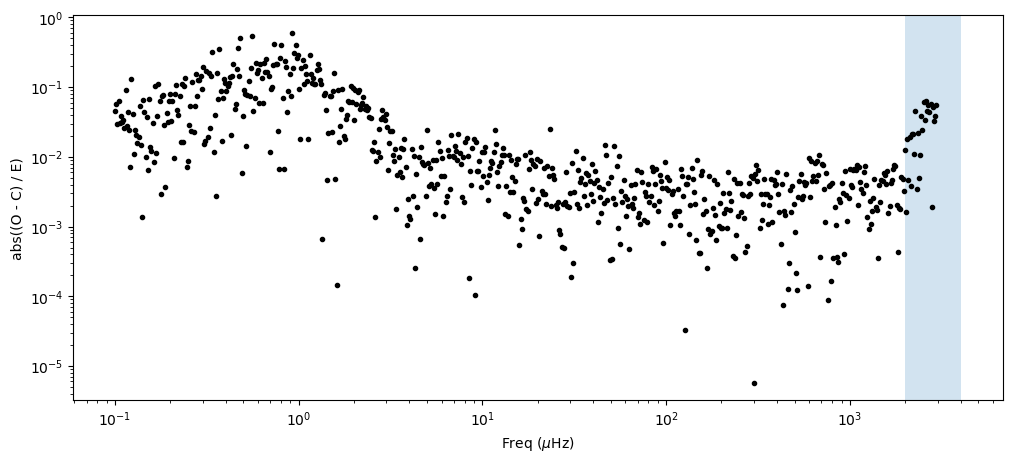

In [11]:
yerr_diagnostic_plot = True

if yerr_diagnostic_plot: 
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.loglog(
        x, np.abs((y - numpy_model(bestp_lowfreq)) / yerr), 'k.',
    )
    ax.set(
        xlabel='Freq ($\\mu$Hz)', ylabel='abs((O - C) / E)'
    )
    ax.axvspan(min_p_mode, max_p_mode, alpha=0.2)

Define functions for the p-mode only fit:

In [14]:
from astropy.table import Table
import math
def str_to_float(x):
    if type(x) is float and math.isnan(x):
        return np.ma.masked
    if type(x) is int:
        return x
    return float(x.split(" $\\pm$ ")[0])

str_astropy = Table.read("data/broomhall2009_table2.tex", format='latex', data_start=5)
str_np = str_astropy.to_pandas().to_numpy()
float_table = Table(rows=[list(map(str_to_float, row)) for row in str_np], names=str_astropy.colnames)
low_order_mode_frequencies = float_table[float_table.colnames[1:]].to_pandas().to_numpy()
ell_labels = np.mgrid[:low_order_mode_frequencies.shape[0], :low_order_mode_frequencies.shape[1]][1]

nans = np.isnan(low_order_mode_frequencies.ravel())
ell_labels = ell_labels.ravel()[~nans]
low_order_mode_frequencies = low_order_mode_frequencies.ravel()[~nans]

In [17]:
Table(
    [low_order_mode_frequencies * u.uHz, ell_labels], 
    names='nu degree'.split()
)#.write('data/broomhall2009_table2_labeled.ecsv')

nu,degree
uHz,
float64,int64
972.613,0
1185.592,1
1263.162,0
1329.629,1
1394.68,2
1407.481,0
1472.836,1
1535.862,2


In [18]:
tab = Table.read('data/broomhall2009_table2_labeled.ecsv').to_pandas().to_numpy()

In [20]:
# np.savetxt('data/broomhall2009_table2_labeled.txt', np.vstack([low_order_mode_frequencies, ell_labels]).T, fmt=('%.8e', '%d'))

In [21]:
# !cp data/broomhall2009_table2_labeled.ecsv ~/git/gadfly/gadfly/data/.

In [22]:
!tail data/broomhall2009_table2_labeled.txt

3.70338600e+03 2
3.76291100e+03 3
3.71097200e+03 0
3.77743000e+03 1
3.84009600e+03 2
3.90001300e+03 3
3.84727700e+03 0
3.91397400e+03 1
3.97735000e+03 2
3.98452700e+03 0


In [23]:
# unique_freqs = np.unique(low_order_mode_frequencies[~np.isnan(low_order_mode_frequencies)])

# _, rows, cols = np.argwhere(unique_freqs[:, None, None] == low_order_mode_frequencies[None, ...]).T

In [24]:
low_order_mode_frequencies = jnp.array(low_order_mode_frequencies)
ell_labels = jnp.array(ell_labels)

In [25]:
# omegas = 2*np.pi*p_mode_freqs.value
# n = len(omegas)
# _, rows, cols = jnp.argwhere(
#     omegas[:, None, None] == 2*np.pi*low_order_mode_frequencies[None, ...]
# ).T
# mask_l0 = jnp.where(cols == 0, 1, 0)
# mask_l1 = jnp.where(cols == 1, 1, 0)
# mask_l2 = jnp.where(cols == 2, 1, 0)    
# mask_l3 = jnp.where(cols == 3, 1, 0)    
# log_Qs = jnp.broadcast_to(log_Q, (n, 4))

# log_S0s = jnp.broadcast_to(
#     jnp.array([log_S0_ell_0, log_S0_ell_1, log_S0_ell_2, log_S0_ell_3]), 
#     (n, 4)
# )

# out = jnp.stack([log_S0s, low_order_mode_frequencies, log_Qs])

In [26]:
# class SHOTermUnderdamped(terms.SHOTerm):
#     def get_coefficients(self):
#         return super().get_underdamped_coefficients()
    
# class TermConvolutionUnderdamped(terms.TermConvolution):
#     def __init__(self, term, delta):
#         self.delta = jnp.float64(delta)
#         self.coefficients = (*term.get_overdamped_coefficients(), *term.get_underdamped_coefficients())
#         self.over = term.get_overdamped_coefficients()
#         self.under = term.get_underdamped_coefficients()
        
#     def get_psd(self, omega):
#         omega = jnp.atleast_1d(omega)
#         psd0 = super()._get_psd_real(self.over, omega)
#         psd0 += super()._get_psd_complex(self.under, omega)
#         arg = 0.5 * self.delta * omega
#         arg += 1e-8 * (jnp.abs(arg) < 1e-8) * jnp.sign(arg)
#         sinc = jnp.sin(arg) / arg
#         return psd0 * sinc**2

In [27]:
import jax

def custom_sho_get_coeffs(self):
    """
    Discussed in this issue:
    https://github.com/exoplanet-dev/celerite2/issues/75
    """
    ar, cr = self.get_overdamped_coefficients()
    ac, bc, cc, dc = self.get_underdamped_coefficients()
    cond = jnp.less(self.Q, 0.5)
    selectr = lambda x: jax.lax.cond(cond, lambda y: y, jnp.zeros_like, operand=x)
    selectc = lambda x: jax.lax.cond(cond, jnp.zeros_like, lambda y: y, operand=x)
    return selectr(ar), selectr(cr), selectc(ac), selectc(bc), selectc(cc), selectc(dc)

terms.SHOTerm.get_coefficients = custom_sho_get_coeffs
# sho = terms.SHOTerm(S0=1, w0=3000, Q=0.6)
# sho.get_coefficients()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def _sho_psd(omega, S0, w0, Q):
    """
    Stochastically driven, damped harmonic oscillator.
    """
    # This is the celerite2 SHO PSD:
    return (
        np.sqrt(2/np.pi) * S0 * w0**4 /
        ((omega**2 - w0**2)**2 + (omega**2 * w0**2 / Q**2))
    )

omega = 3000 # np.logspace(-1, 3)[:, None] #3000
S0 = np.array([10, 50, 100])#[None, :]
w0 = np.array([5000, 200, 10])#[None, :]
Q = np.array([0.6, 0.6, 0.6])#[None, :]

print(_sho_psd(omega, S0, w0, Q).sum())

# plt.loglog(omega, _sho_psd(omega, S0, w0, Q).sum(1))

5.661146840535773


In [102]:
nu_max = 3079.76 * u.uHz  # central peak p-mode frequency from Kiefer 2018

# Scale factor for the the p-mode peak amplitudes:
# scaled_intensities = scale._p_mode_intensity_kjeldsen_bedding(low_order_mode_frequencies * u.uHz).value/20.1
scaled_intensities = scale.p_mode_intensity(
    scale._solar_temperature, low_order_mode_frequencies * u.uHz, 
    scale._solar_nu_max, scale._solar_delta_nu, wavelength=550*u.nm
)

log_Q = 3.3

# log_Q_left = 2.9 #3.1
# log_Q_right = 3.4 #3.3
# log_S0_ell_2 = -5.5
# log_S0_ell_3 = -6.4
# log_S0_ell_1 = -5.2
# log_S0_ell_0 = -5.2

log_S0_ell_0 = -5.5 + 0.3
log_S0_ell_1 = -5.4 + 0.3
log_S0_ell_2 = -5.6 + 0.3
log_S0_ell_3 = -6.6 + 0.3

# S0_ell_0 = 10 ** -5.5
# S0_ell_1 = 10 ** -5.4
# S0_ell_2 = 10 ** -5.95
# S0_ell_3 = 10 ** -6.6

# log_Q_ell_0 = 3.4
# log_Q_ell_1 = 3.4
# log_Q_ell_2 = 3.35
# log_Q_ell_3 = 3.3

# Q_ell_0 = 10 ** 3.4
# Q_ell_1 = 10 ** 3.4
# Q_ell_2 = 10 ** 3.2
# Q_ell_3 = 10 ** 3.3


log_Q_ell_0 = 3.4
log_Q_ell_1 = 3.4
log_Q_ell_2 = 3.2
log_Q_ell_3 = 3.3

# @jit
# def sho_psd(omega, S0, w0, Q):
#     """
#     Stochastically driven, dampled harmonic oscillator.
#     """
#     # What follows is the usual celerite2 SHO PSD:
#     return np.sqrt(2/np.pi) * S0 * w0**4 / ((omega**2 - w0**2)**2 + (omega**2 * w0**2 / Q**2))

@jit
def insert_omegas(initp, omegas=2*np.pi*low_order_mode_frequencies, ell_labels=ell_labels):
    (log_S0_ell_0, log_S0_ell_1, log_S0_ell_2, log_S0_ell_3, 
     log_Q_ell_0, log_Q_ell_1, log_Q_ell_2, log_Q_ell_3) = initp

    mask_l0 = jnp.where(ell_labels == 0, 1, 0)
    mask_l1 = jnp.where(ell_labels == 1, 1, 0)
    mask_l2 = jnp.where(ell_labels == 2, 1, 0)    
    mask_l3 = jnp.where(ell_labels == 3, 1, 0)    

    log_S0s = (
        mask_l0 * log_S0_ell_0 + 
        mask_l1 * log_S0_ell_1 + 
        mask_l2 * log_S0_ell_2 + 
        mask_l3 * log_S0_ell_3
    )
    
    log_Qs = (
        mask_l0 * log_Q_ell_0 + 
        mask_l1 * log_Q_ell_1 + 
        mask_l2 * log_Q_ell_2 + 
        mask_l3 * log_Q_ell_3
    )

    out = jnp.stack([log_S0s, omegas, log_Qs]).T
    return out

@jit 
def scaled(hyperparams, scaled_intensities=scaled_intensities):
    """
    Scale the S0 hyperparameters by their scaling in
    Kiefer et al. (2018)
    """
    scaled_S0_column = hyperparams[:, 0] + jnp.log10(scaled_intensities)
    # scaled_S0_column = hyperparams[:, 0] * scaled_intensities
    return jnp.vstack([scaled_S0_column, hyperparams[:, 1:].T]).T


delta = (1*u.min).to(1/u.uHz).value

# @jit
# def p_mode_model(p, omega, delta=delta):
#     sho_hyperparams = insert_omegas(p)
#     sho_hyperparams = scaled(sho_hyperparams)
    
#     sum_terms = [
#         terms.SHOTerm(
#                 S0=jnp.power(10.0, log_S0), w0=w0, Q=log_Q # Q=jnp.power(10.0, log_Q)
#             )
#         for log_S0, w0, log_Q in sho_hyperparams
#     ]
#     # background term:
#     background = 1
#     return terms.TermConvolution(terms.TermSum(*sum_terms), delta).get_psd(omega) + background


# @jit
# def p_mode_model(p, omega, delta=delta):
#     sho_hyperparams = insert_omegas(p)
#     sho_hyperparams = scaled(sho_hyperparams)
    
#     sum_terms = [
#         terms.TermConvolution(
#             SHOTermUnderdamped(
#                     S0=jnp.power(10.0, log_S0), w0=w0, Q=log_Q # Q=jnp.power(10.0, log_Q)
#             ), delta
#         )
#         for log_S0, w0, log_Q in sho_hyperparams
#     ]
#     # background term:
#     background = 1
#     return terms.TermSum(*sum_terms).get_psd(omega) + background

@jit
def p_mode_model(p, omega, delta=delta):
    sho_hyperparams = insert_omegas(p)
    sho_hyperparams = scaled(sho_hyperparams)
    
    # sum_terms = [
    #     TermConvolutionUnderdamped(
    #         terms.SHOTerm(
    #                 S0=jnp.power(10.0, log_S0), w0=w0, Q=log_Q # Q=jnp.power(10.0, log_Q)
    #         ), delta
    #     ).get_psd(omega)
    #     for log_S0, w0, log_Q in sho_hyperparams
    # ]
    
    def f(carry, x):
        log_S0, w0, log_Q = x
        return carry, terms.TermConvolution(
            terms.UnderdampedSHOTerm(
                    S0=jnp.power(10.0, log_S0), w0=w0, Q=jnp.power(10.0, log_Q)
            ), delta
        ).get_psd(omega)
    # background term:
    background = 1
    return jnp.sum(lax.scan(f, 0, sho_hyperparams)[1], axis=0) + background
    

In [103]:
initp = jnp.array([log_S0_ell_0, log_S0_ell_1, log_S0_ell_2, log_S0_ell_3, log_Q_ell_0, log_Q_ell_1, log_Q_ell_2, log_Q_ell_3])
# initp = jnp.array([log_S0_ell_0, log_S0_ell_1, log_S0_ell_2, log_S0_ell_3, Q_ell_0, Q_ell_1, Q_ell_2, Q_ell_3])

To do the p-mode only fit, we will normalize out the low-frequency fit. Also normalize out a polynomial baseline trend.

In [104]:
norm_lowfreq = low_freq_kernels_five_kernels(bestp_lowfreq).get_psd(2*np.pi*p_mode_binned.frequency) 

poly_order = 5
poly_fit_x = (p_mode_binned.frequency - p_mode_binned.frequency.mean()).value
poly_fit_y = p_mode_binned.power / norm_lowfreq
norm_corr = np.polyval(np.polyfit(
    poly_fit_x,
    poly_fit_y,
    poly_order,
    w=1/poly_fit_y/p_mode_binned.error,
), poly_fit_x)

mask_outliers = poly_fit_y / norm_corr < 200 * poly_fit_y.unit
forced_error = np.ones_like(poly_fit_y) * 1 #np.sqrt(poly_fit_y / norm_corr) / 5
p_mode_binned_normed = PowerSpectrum(
    p_mode_binned.frequency[mask_outliers], 
    (poly_fit_y / norm_corr)[mask_outliers], 
    error=forced_error[mask_outliers]
)#.cutout(
#     frequency_min=2500 * u.uHz,
#     frequency_max=3500 * u.uHz
# )

init_model = p_mode_model(initp, omega=2*np.pi*p_mode_binned_normed.frequency.value)

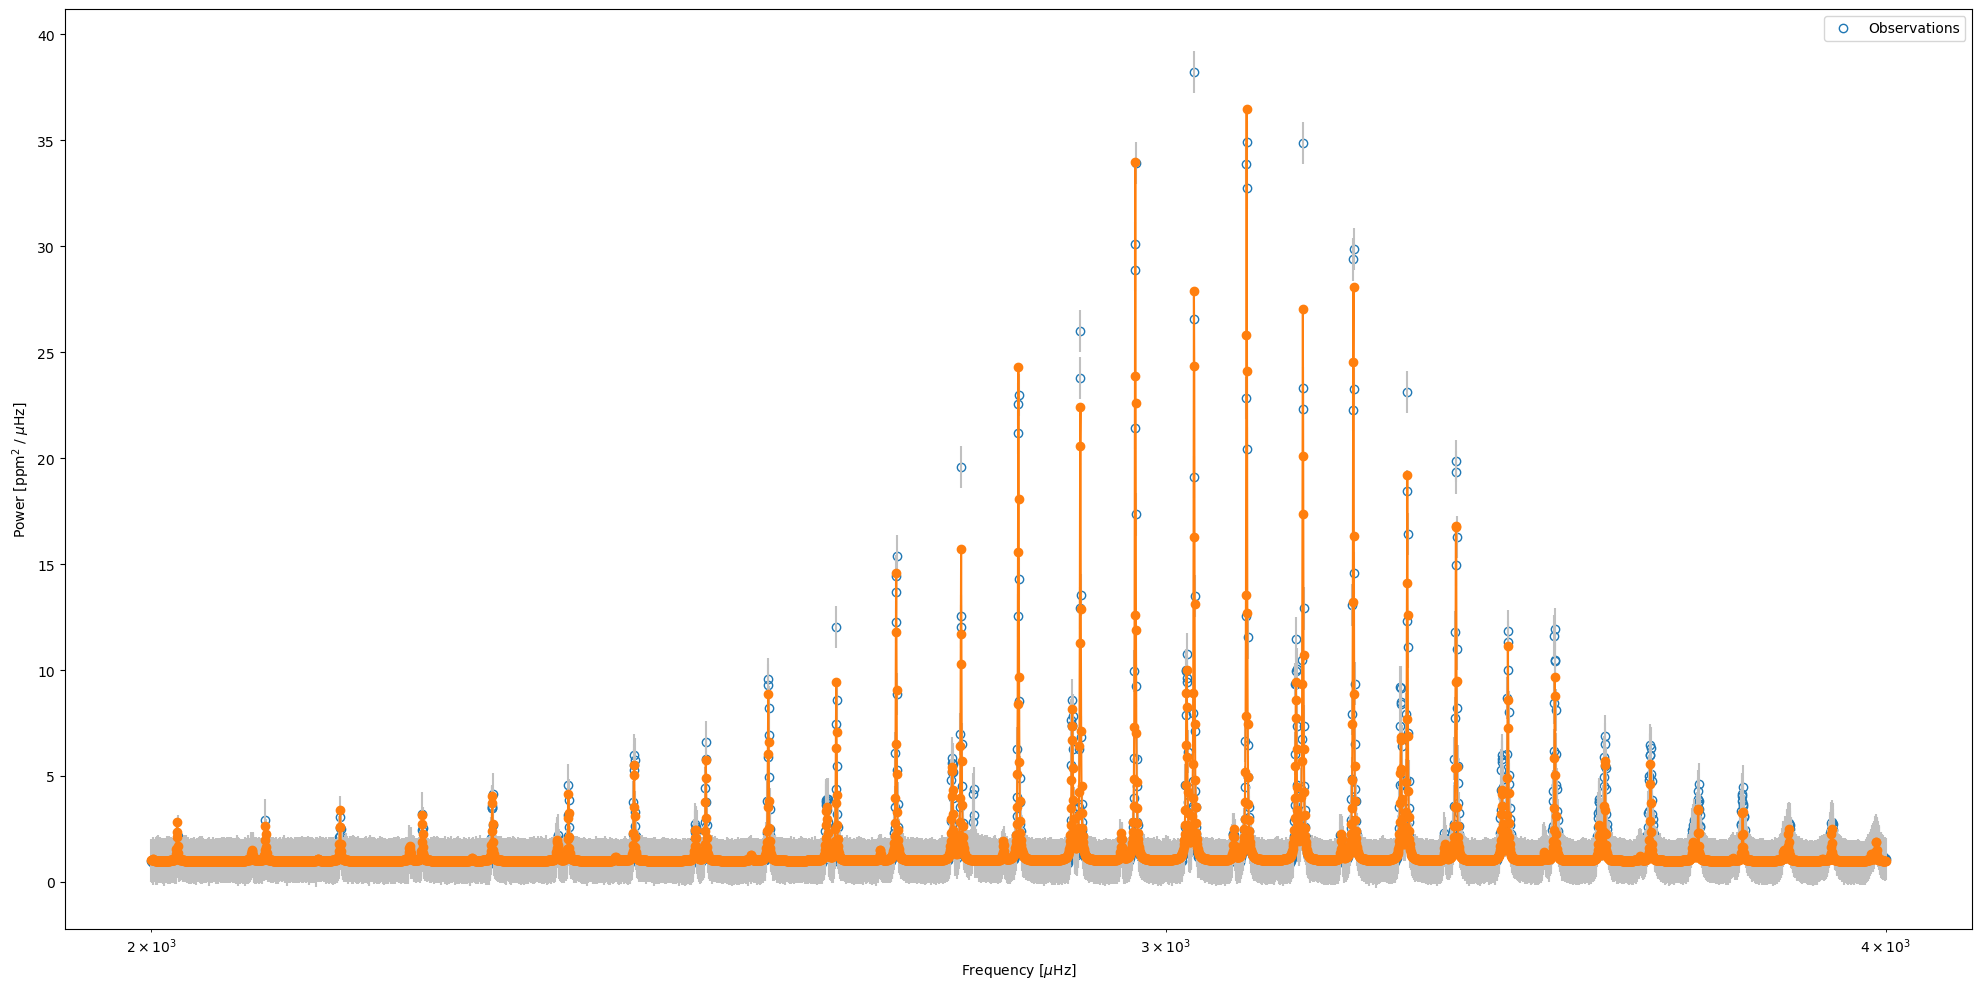

In [105]:
fig = plt.figure(figsize=(20, 10))
p_mode_binned_normed.plot(ax=plt.gca())

plt.errorbar(p_mode_binned_normed.frequency.value, p_mode_binned_normed.power.value, p_mode_binned_normed.error.value, ecolor='silver', fmt='none')
near_modes = np.ones_like(p_mode_binned_normed.frequency.value).astype(bool) 
#np.logical_or.reduce(np.array([np.abs(p_mode_binned_normed.frequency.value - pf) < 25 for pf in low_order_mode_frequencies]))

plt.plot(p_mode_binned_normed.frequency.value[near_modes], init_model[near_modes], marker='o')
plt.gca().set_yscale("linear")
# plt.gca().set_xscale("linear")
# plt.xlim([3000, 3050])  # l=2, l=0
# plt.xlim([3070, 3110])  # l=3, l=1

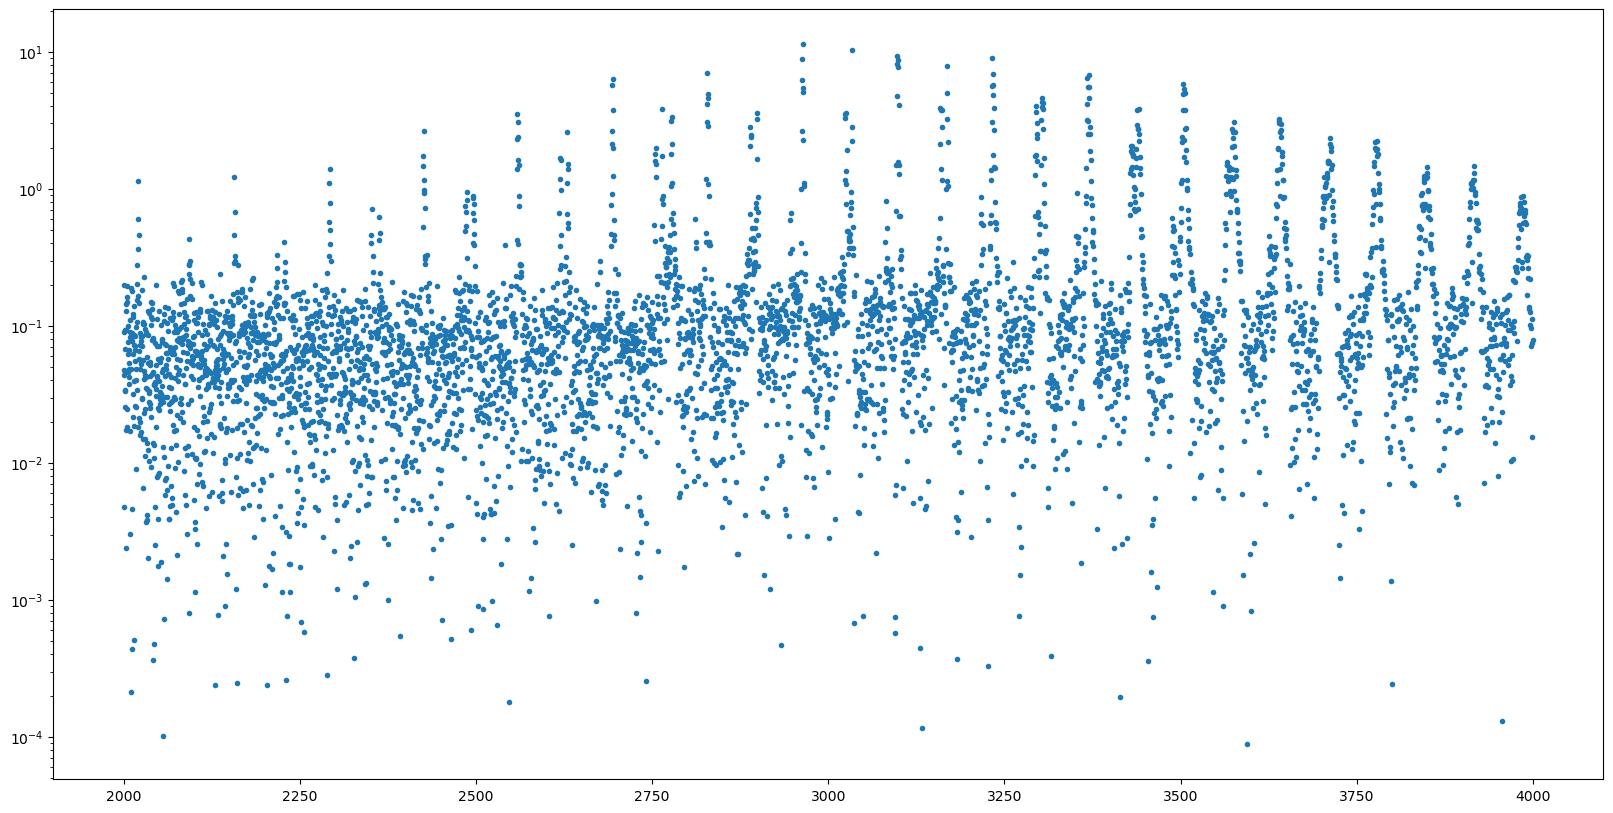

In [106]:
fig = plt.figure(figsize=(20, 10))
plt.semilogy(p_mode_binned_normed.frequency.value[near_modes], np.abs(p_mode_binned_normed.power.value[near_modes] - init_model[near_modes]) / p_mode_binned_normed.error.value[near_modes], '.')
# plt.gca().set_yscale("linear")
# plt.gca().set_xscale("linear")
# plt.xlim([3000, 3050])  # l=2, l=0
# plt.xlim([3070, 3110])  # l=3, l=1

Using the model generated from the initial parameters, we'll mask out power spectrum measurements that are close to the background by masking out observations where the excess power is expected to be small.

In [107]:

# mask_below_background_threshold = False

# if mask_below_background_threshold:
#     background_threshold = 1e-2
#     near_modes = (
#         init_model > 1 + 
#         background_threshold
#     )

#     plt.figure(figsize=(20, 6))
#     plt.errorbar(
#         p_mode_binned_normed.frequency[near_modes], 
#         p_mode_binned_normed.power[near_modes].value, 
#         p_mode_binned_normed.error[near_modes].value, 
#         fmt='.', ecolor='silver')

#     plt.semilogy(p_mode_binned_normed.frequency.value, init_model, zorder=5)
#     plt.ylim([0, 15])
# else: 
#     near_modes = np.ones_like(init_model).astype(bool)

In [108]:
def chi2_p_modes(
    p,
    y=p_mode_binned_normed.power.value[near_modes], 
    omega=2*np.pi*p_mode_binned_normed.frequency.value[near_modes], 
    yerr=p_mode_binned_normed.error.value[near_modes]
):
    """
    chi^2 of the low-frequency model
    """
    chi2_result = jnp.nansum( 
        (y - p_mode_model(p, omega))**2 / yerr**2
    )
    return chi2_result

Run the fit for the p-mode oscillations:

In [109]:
# from jax import config

# config.update('jax_debug_nans', True)

In [110]:
# result = minimize(chi2_p_modes, initp, method='bfgs') 
# if result.success:
#     print("Fit successful!")
# elif result.status == 3:
#     # status message keys source/docs
#     # https://github.com/scipy/scipy/blob/85d25b6e4a9b95371e48bae75c19459a0b77d18e/scipy/optimize/_optimize.py#L1239-L1242
#     print('Warning: nans encountered in optimization')

# # These are the best-fit parameters:
# bestp_p_modes = result.x
# bestp_p_modes

In [111]:
from jaxopt import ScipyBoundedMinimize

lbfgsb = ScipyBoundedMinimize(fun=chi2_p_modes, method="l-bfgs-b", maxiter=10000)
lower_bounds = jnp.ones_like(initp) * -10
upper_bounds = jnp.ones_like(initp) * 10
bounds = (lower_bounds, upper_bounds)
soln = lbfgsb.run(initp, bounds=bounds)

bestp_p_modes = soln.params

In [112]:
soln.params

Array([-5.14504182, -4.75691421, -5.02521991, -6.07609603,  3.42137685,
        3.24050831,  3.10924098,  3.1535935 ], dtype=float64)

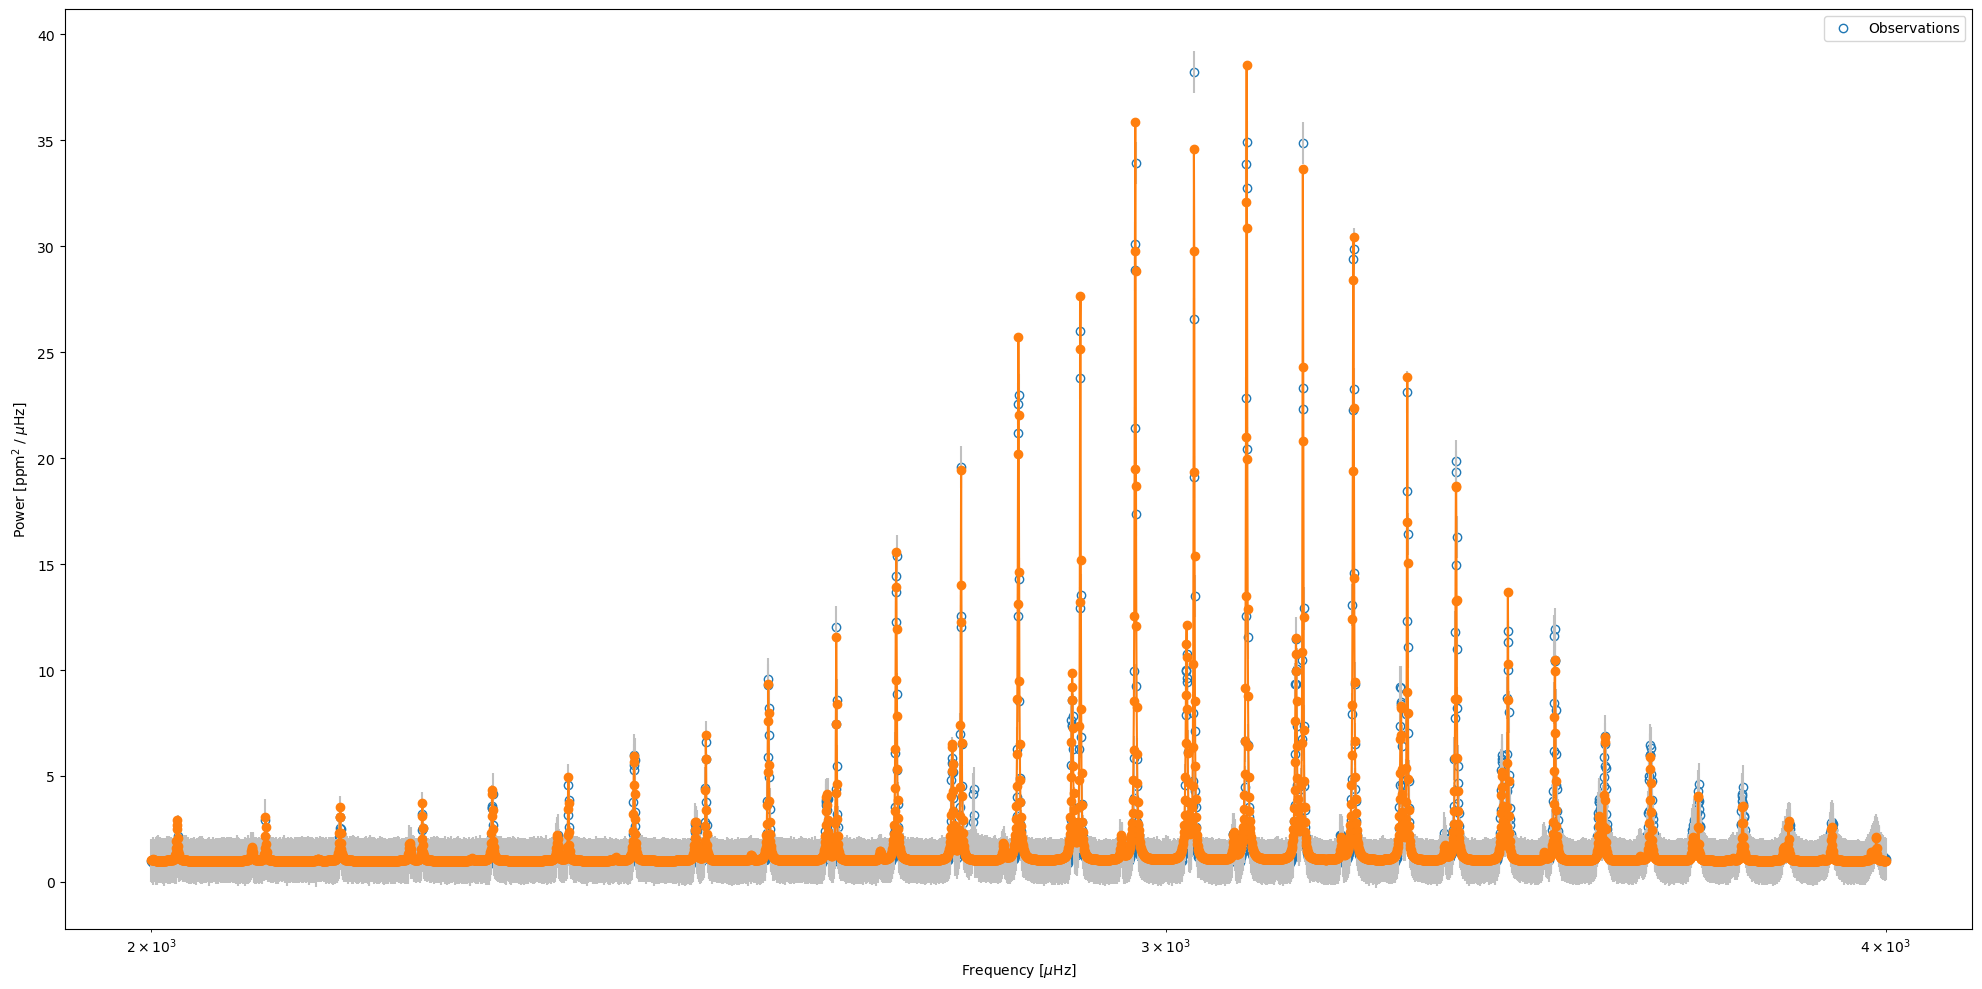

In [115]:
fig = plt.figure(figsize=(20, 10))
p_mode_binned_normed.plot(ax=plt.gca())
bestp_model = p_mode_model(bestp_p_modes, omega=2*np.pi*p_mode_binned_normed.frequency.value)
plt.errorbar(p_mode_binned_normed.frequency.value, p_mode_binned_normed.power.value, p_mode_binned_normed.error.value, ecolor='silver', fmt='none')
plt.plot(p_mode_binned_normed.frequency.value[near_modes], bestp_model[near_modes], marker='o')
plt.gca().set_yscale("linear")
# plt.gca().set_xscale("linear")
# plt.xlim([3000, 3050])  # l=2, l=0
# plt.xlim([3070, 3110])  # l=3, l=1

In [116]:
def p_mode_dicts(p, p_mode_frequencies=p_mode_freqs['nu']):
    sho_hyperparams = insert_omegas(p)
    sho_hyperparams = scaled(sho_hyperparams)
    hp = []
    for x in sho_hyperparams:
        log_S0, w0, log_Q = x
        background = np.float64(low_freq_kernels_five_kernels(bestp_lowfreq).get_psd(w0))
        hp.append(dict(S0=np.power(10.0, log_S0) * background, w0=np.float64(w0), Q=np.power(10.0, log_Q)))
    return hp

p_mode_list = p_mode_dicts(bestp_p_modes)

In [117]:
log_S0_ell_2_bestp, log_S0_ell_3_bestp, log_S0_ell_0_bestp, log_S0_ell_1_bestp = bestp_p_modes[:4]

def p_mode_S0_labels(p, p_mode_frequencies=p_mode_freqs['nu']):
    sho_hyperparams = insert_omegas(p, omegas=2*np.pi*p_mode_frequencies)
    sho_hyperparams = scaled(sho_hyperparams)
    top_labels = []
    for x in sho_hyperparams:
        log_S0, w0, log_Q = x
        # print('log_S0', log_S0)
        if log_S0_ell_2_bestp == log_S0:    
            top_labels.append("$\ell = 2$")
        elif log_S0_ell_3_bestp == log_S0:    
            top_labels.append("$\ell = 3$")
        elif log_S0_ell_0_bestp == log_S0:
            top_labels.append("$\ell = 0$")
        elif log_S0_ell_1_bestp == log_S0:
            top_labels.append("$\ell = 1$")

    return top_labels

In [118]:
# Convert the best-fit parameters from the low-frequencies to an array
# with shape (5, 3) = (n_terms, n_hyperparams_per_term)
bestp_lowfreq_array = np.vstack([jax_parameterization_to_linear_space(bestp_lowfreq), fixed_Q * np.ones(5)]).T

# convert the array format hyperparams to a list of dict:
bestp_lowfreq_list = []

for S0, w0, Q in bestp_lowfreq_array:
    bestp_lowfreq_list.append(
        dict(
            hyperparameters=dict(
                S0=S0, w0=w0, Q=Q
            ), 
            metadata=dict(
                #fixed_parameters=['Q'] if Q == fixed_Q else ['w0']
                source='granulation'
            )
            # S0=S0, w0=w0, Q=Q
        )
    )

In [119]:
all_hyperparameters = [*bestp_lowfreq_list]
ell_modes = [0, 1, 2, 3]

for ell_mode, p_mode_params in zip(ell_modes, np.reshape(soln.params, (2, 4)).T):
    S0, Q = np.power(10.0, p_mode_params)
    all_hyperparameters.append(
        dict(
            hyperparameters=dict(S0=S0, Q=Q), 
            metadata=dict(
                degree=ell_mode,
                source='oscillation'
            )
        )    
    )

# for p in p_mode_list:
#     all_hyperparameters.append(
#         dict(
#             hyperparameters=p, 
#             metadata=dict(
#                 fixed_parameters=['Q'] if p['Q'] == fixed_Q else ['w0']
#             )
#         )
#     )

In [120]:
all_hyperparameters

[{'hyperparameters': {'S0': 18340.835205958254,
   'w0': 5.35321843959353,
   'Q': 0.6},
  'metadata': {'source': 'granulation'}},
 {'hyperparameters': {'S0': 17.89841172794779,
   'w0': 114.55520319850163,
   'Q': 0.6},
  'metadata': {'source': 'granulation'}},
 {'hyperparameters': {'S0': 0.5659662607164637,
   'w0': 575.893886406892,
   'Q': 0.6},
  'metadata': {'source': 'granulation'}},
 {'hyperparameters': {'S0': 0.2960462107291726,
   'w0': 5050.277958149664,
   'Q': 0.6},
  'metadata': {'source': 'granulation'}},
 {'hyperparameters': {'S0': 0.07160842899044823,
   'w0': 20343.609557336833,
   'Q': 0.6},
  'metadata': {'source': 'granulation'}},
 {'hyperparameters': {'S0': 7.160744534863139e-06, 'Q': 2638.6200296239595},
  'metadata': {'degree': 0, 'source': 'oscillation'}},
 {'hyperparameters': {'S0': 1.7501924007383615e-05, 'Q': 1739.8359964306403},
  'metadata': {'degree': 1, 'source': 'oscillation'}},
 {'hyperparameters': {'S0': 9.435829574482945e-06, 'Q': 1286.0000231757188}

In [121]:
all_terms = []

for trm in low_freq_kernels_five_kernels(bestp_lowfreq).terms:
    all_terms.append(trm)

for hp in p_mode_list:
    all_terms.append(terms.SHOTerm(**hp))

In [122]:
delta = (1*u.min).to(1/u.uHz).value
# kernel_all_terms = terms.TermSum(*[terms.TermConvolution(trm, delta) for trm in all_terms])

from gadfly import SolarOscillatorKernel
kernel_all_terms = SolarOscillatorKernel(texp=1*u.min, bandpass='SOHO VIRGO')

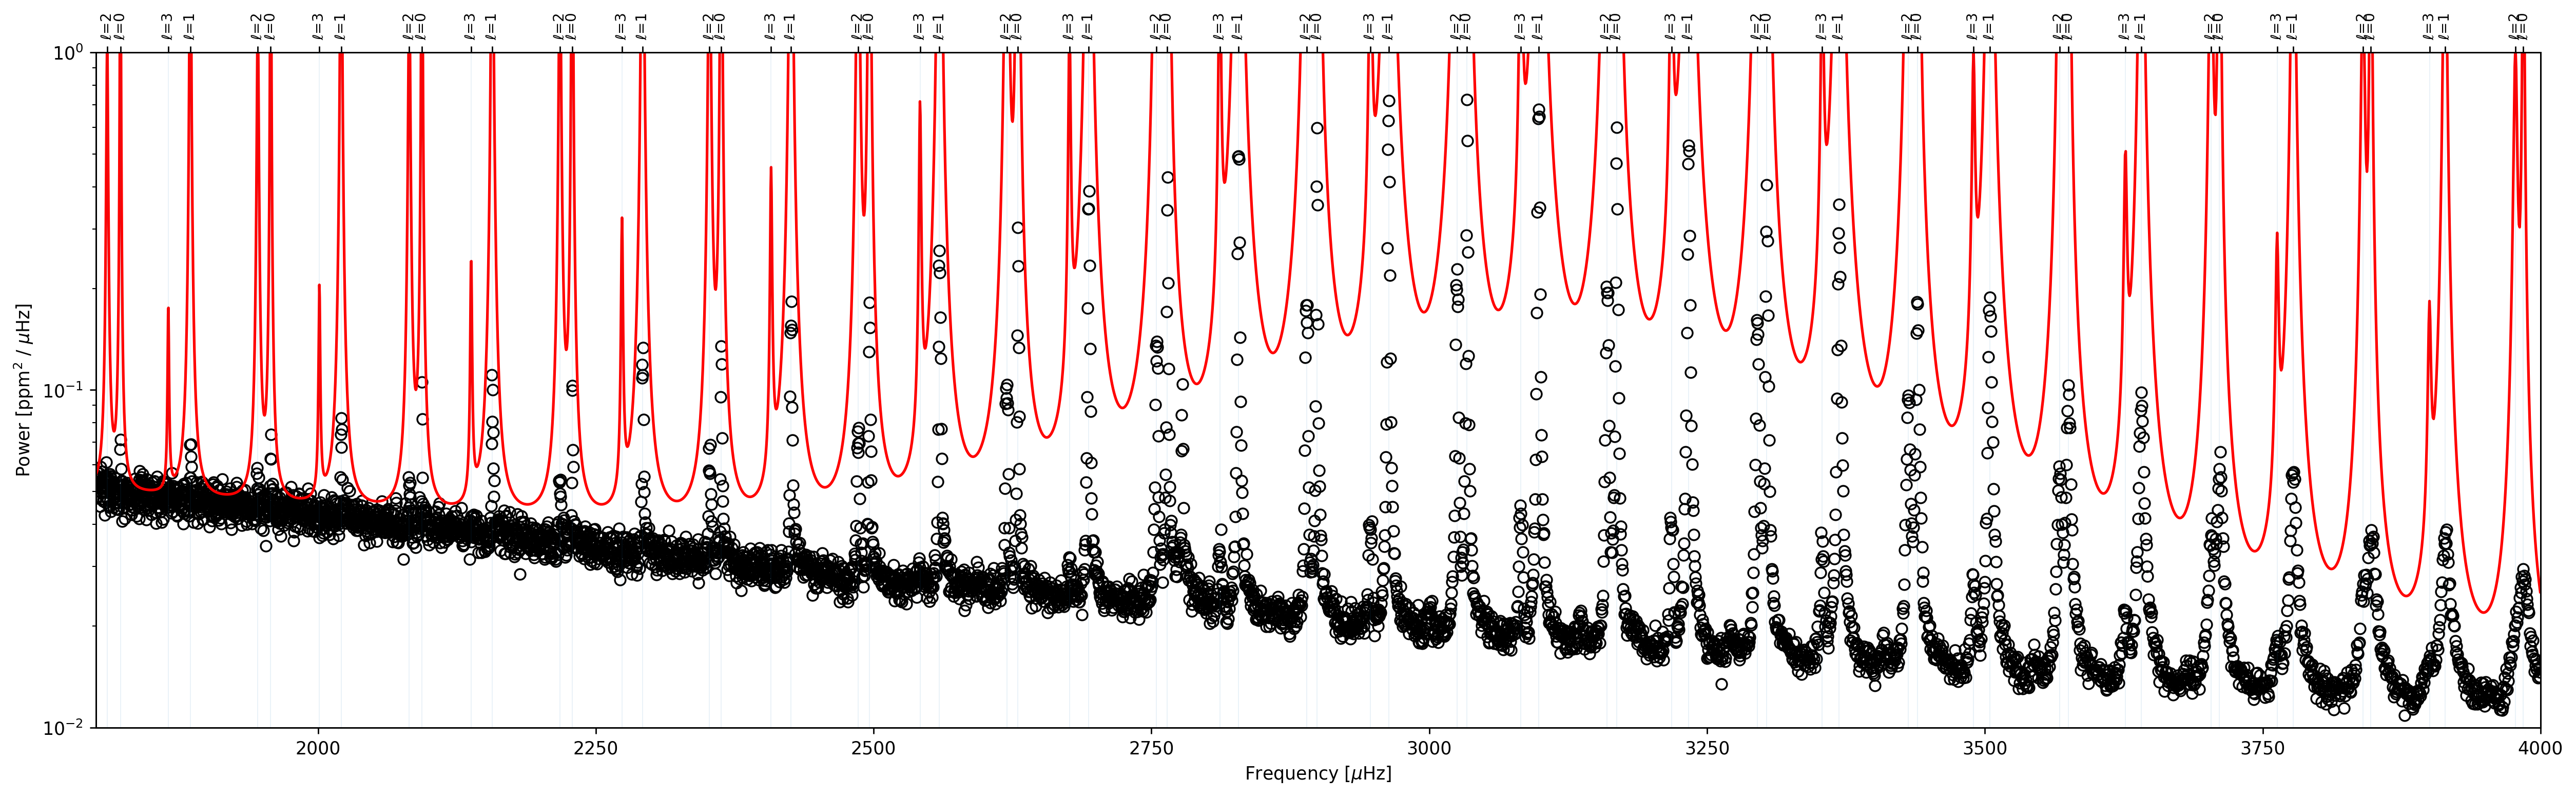

In [123]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=250)

p_mode_bin_for_plot.plot(
    ax=ax, p_mode_inset=False, scaling_low_freq='semilogy', legend=False, obs_kwargs=dict(color='k', rasterized=True)
)
ax.plot(
    p_mode_bin_for_plot.frequency.value, 
    kernel_all_terms.get_psd(2 * np.pi * p_mode_bin_for_plot.frequency.value), color='r'
)
ax.set(xlim=(1800, 4000), ylim=(1e-2, 1))


broomhall_freq = []
broomhall_label = []
for col in float_table.colnames[1:]:
    for row in float_table[col]:
        if not np.ma.is_masked(row):
            broomhall_freq.append(row)
            broomhall_label.append(col)
            ax.axvline(row, lw=0.5, alpha=0.1)
ax2 = ax.twiny()
ax2.set(
    xticks=broomhall_freq, 
    xticklabels=broomhall_label,
    xlim=ax.get_xlim()
)
plt.setp(ax2.get_xticklabels(), fontsize=8, rotation=90)

plt.savefig('paper/plots/p-modes-old.pdf', bbox_inches='tight')
plt.show()

In [124]:
overwrite = True
parameter_vector_path = 'hyperparameters3.json'
if not os.path.exists(parameter_vector_path) or overwrite:
    with open('hyperparameters3.json', 'w') as w:
        json.dump(all_hyperparameters, w, indent=4)

else: 
    print('skipping overwrite')

In [125]:
!cp hyperparameters3.json ../gadfly/data/hyperparameters.json

In [72]:
hyperparameters = all_hyperparameters

In [79]:
p_mode_hyperparams = [
    item for item in sorted(hyperparameters, key=lambda x: x['metadata'].get('degree', -1))
    if item['metadata']['source'] == 'oscillation'
]

In [86]:
np.transpose(
    [[param_set['hyperparameters'].get(param)
      for param in ['S0', 'Q']]
     for param_set in p_mode_hyperparams]
).ravel()

array([2.67678238e-06, 6.56955259e-06, 3.55158727e-06, 3.15939531e-07,
       2.65017795e+03, 1.74247583e+03, 1.28498283e+03, 1.41808621e+03])